In [1]:
import numpy as np
import logging

from cdr import ClockDataRecoverer
from deframer import Deframer
from demodulator import Demodulator
from audioio import SoundFileSource

logging.basicConfig(level=logging.INFO)

In [12]:
block_size = 4096
filename = "Samples/30bps_alternating_7700_8500.wav"
baudrate = 30

source = SoundFileSource(filename, block_size)

f1_f2_ratios = np.array([], dtype=float)
symbols = np.array([], dtype=bool)
f1_amp = np.array([], dtype=float)
f2_amp = np.array([], dtype=float)
symbol_rising_edges = np.array([], dtype=float)

with source:
    fs = source.fs
    sps = fs // baudrate

    demodulator = Demodulator(
        fs=fs,
        f1=7700,
        f2=8500,
        f_delta=40,
        carrier_bandpass_ntaps=1229,
        symbol_lpf_cutoff_freq=100,
        symbol_lpf_ntaps=1229,
        eps=1e-6,
    )

    cdr = ClockDataRecoverer(
        sps=sps,
        clk_recovery_window=sps // 4,
        clk_recovery_grad_threshold=0.003,
    )

    deframer = Deframer()

    for block in source.stream:
        block_f1_f2_ratios = demodulator.accept(block)
        block_symbols = cdr.accept(block_f1_f2_ratios)
        block_frames = deframer.accept(block_symbols)
        for frame in block_frames:
            print(frame)
        
        f1_f2_ratios = np.concatenate((f1_f2_ratios, block_f1_f2_ratios))
        f1_amp = np.concatenate((f1_amp, demodulator.frag_f1_amp))
        f2_amp = np.concatenate((f2_amp, demodulator.frag_f2_amp))
        symbols = np.concatenate((symbols, block_symbols))
        symbol_rising_edges = np.concatenate((symbol_rising_edges, cdr.symbol_rising_edges))



(30.0, 90.0)

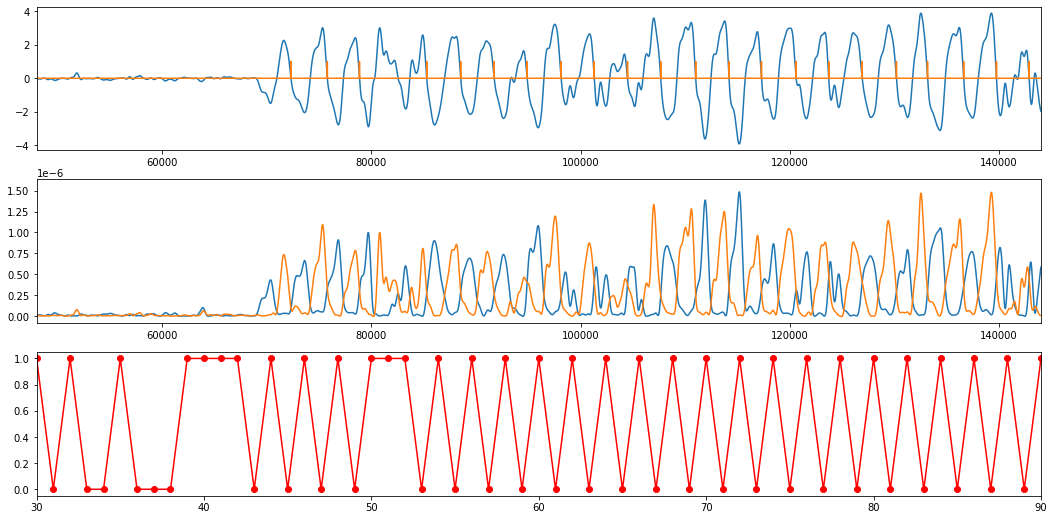

In [13]:
import matplotlib.pyplot as plt

start = 1.0
end = 3.0

plt.figure(1, figsize=(18, 9))
plt.clf()
plt.subplot(311)
plt.plot(-f1_f2_ratios)
plt.plot(symbol_rising_edges)
plt.xlim(start * fs, end * fs)

plt.subplot(312)
plt.plot(f1_amp)
plt.plot(f2_amp)
plt.xlim(start * fs, end * fs)

plt.subplot(313)
plt.plot(symbols, 'ro-')
plt.xlim(start * baudrate, end * baudrate)